In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns

In [17]:
palette1 = sns.color_palette("pastel")
palette = sns.color_palette("deep")

c_scatter = palette[0]
c_line = palette1[1]
c_ci = palette1[1]

In [ ]:
with open("../data/scores_results.json", "r") as f:
    scores = json.load(f)

with open("../data/regression_results.json", "r") as f:
    regs = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'scores_results.json'

In [42]:
def sum(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    m = min(len(a), len(b))
    return a[:m] + b[:m]
    
def min(a, b):
    return np.minimum(a, b)

def max(a, b):
    return np.maximum(a, b)

def avg(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return (a + b) / 2

def havg(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return 2 / ((1 / a) + (1 / b))

In [44]:
def get_xlabel(reg):
    return {
        'ue1' : 'SumEigV',
        'ue2' : 'Second UE',
        'sum' : 'SumEigV + ',
        'max' : 'max(SumEigV, )',
        'min' : 'min(SumEigV, )',
        'avg' : 'Average of UEs',
        'havg' : 'Harmonic Average of UEs'
    }[reg]


def get_xs(reg, d):
    ue1 = d["ue1"]
    ue2 = d["ue2"]

    return {
        "ue1": ue1,
        'ue2' : ue2,
        'sum' : sum(ue1, ue2),
        'max' : max(ue1, ue2),
        'min' : min(ue1, ue2),
        'avg' : avg(ue1, ue2),
        'havg' : havg(ue1, ue2)
    }[reg]

In [ ]:
# # TEST VALUES
# scores = {
#     "Q1": {
#         "ue1": [0.2, 0.5, 0.8],
#         "ue2": [1.0, 0.9, 1.1],
#         "sum": [1.2, 1.4, 1.9],
#         "min": [0.2, 0.5, 0.8],
#         "max": [1.0, 0.9, 1.1],
#         "avg": [0.6, 0.7, 0.95],
#         "havg": [0.33, 0.64, 0.88],
#         "safe_scores": [0, 1, 1]
#     },
#     "Q2": {
#         "ue1": [0.3, 0.4],
#         "ue2": [1.2, 1.05],
#         "sum": [1.5, 1.45],
#         "min": [0.3, 0.4],
#         "max": [1.2, 1.05],
#         "avg": [0.75, 0.725],
#         "havg": [0.46, 0.69],
#         "safe_scores": [1, 0]
#     }
# }


# regs = {
#     "ue1":  {"slope": 1.2, "intercept": 0.1, "correlation": 0.7},
#     "ue2":  {"slope": -0.4, "intercept": 1.0, "correlation": -0.3},
#     "sum":  {"slope": 0.8, "intercept": 0.2, "correlation": 0.5},
#     "min":  {"slope": 1.1, "intercept": -0.1, "correlation": 0.6},
#     "max":  {"slope": -0.7, "intercept": 1.3, "correlation": -0.4},
#     "avg":  {"slope": 0.5, "intercept": 0.4, "correlation": 0.4},
#     "havg": {"slope": 0.2, "intercept": 0.6, "correlation": 0.2}
# }


(5,)


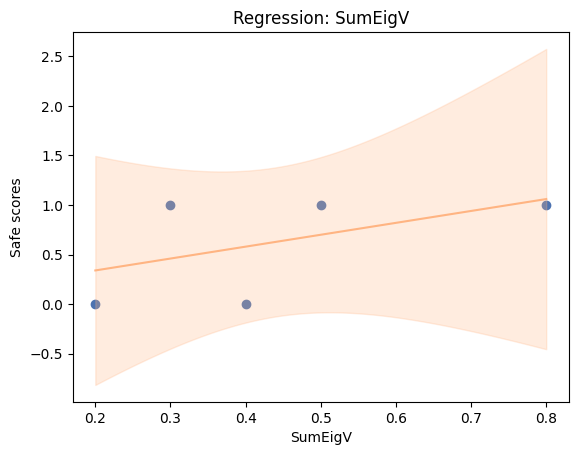

(5,)


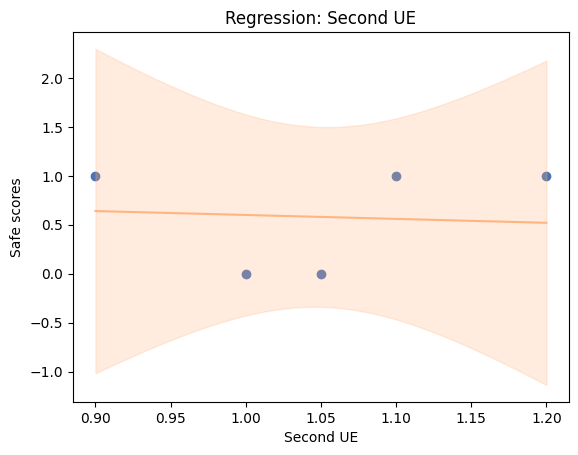

(5,)


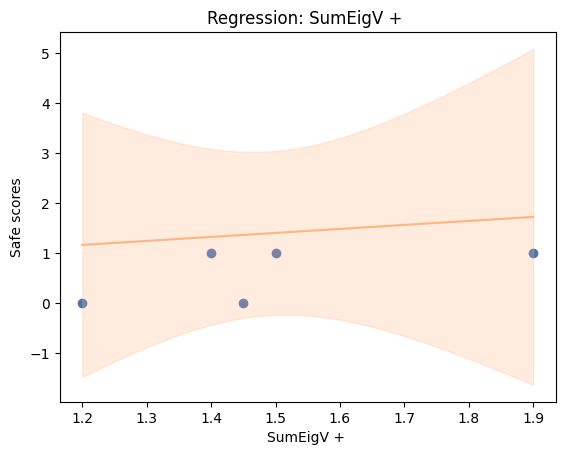

(5,)


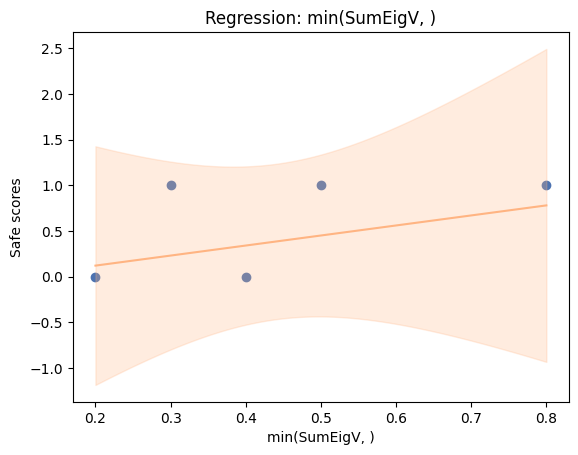

(5,)


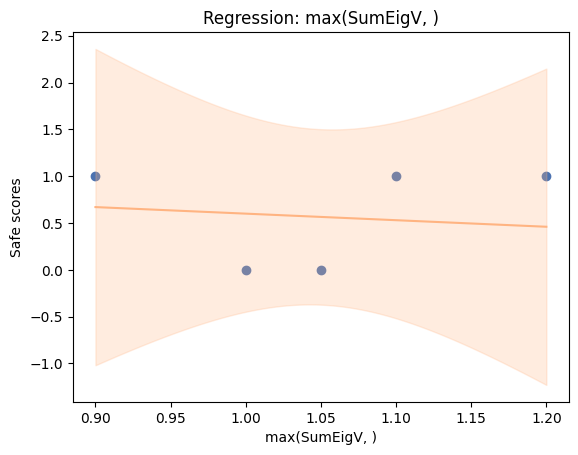

(5,)


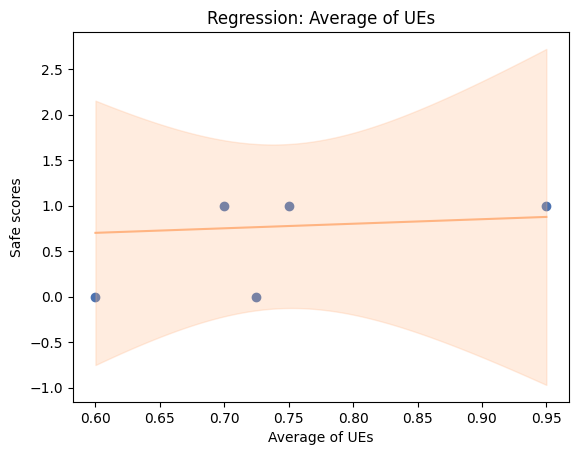

(5,)


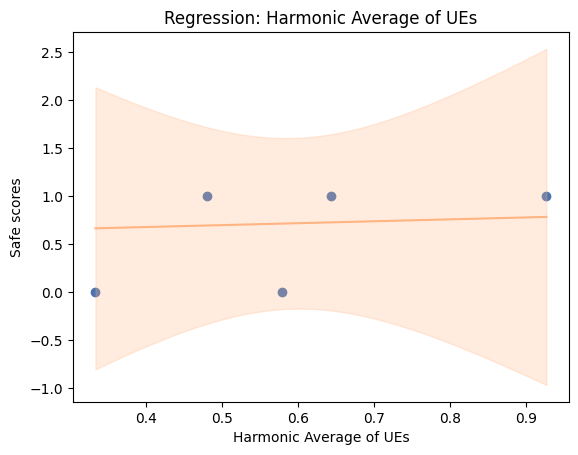

In [ ]:
reg_keys = ['ue1', 'ue2', 'sum', 'min', 'max', 'avg', 'havg']
for reg in reg_keys:
    slope = regs[reg]["slope"]
    intercept = regs[reg]["intercept"]

    all_x = []
    all_y = []

    for qid, d in scores.items():
        # pick the matching variable for the regression chosen
        x_vals = get_xs(reg, d)
        y_vals = d["safe_scores"]

        # extend all
        all_x.extend(x_vals)
        all_y.extend(y_vals)

    x = np.array(all_x)
    y = np.array(all_y)

    print(x.shape)

    x_line = np.linspace(x.min(), x.max(), 200)
    y_line = intercept + slope * x_line

    n = len(x)
    y_pred = intercept + slope * x
    residuals = y - y_pred
    s_err = np.sqrt(np.sum(residuals**2) / (n - 2))

    t_val = t.ppf(0.975, df=n - 2)
    ci = t_val * s_err * np.sqrt(
        1/n + (x_line - np.mean(x))**2 / np.sum((x - np.mean(x))**2)
    )

    upper = y_line + ci
    lower = y_line - ci


    plt.scatter(x, y, color=c_scatter)
    plt.plot(x_line, y_line, color=c_line)
    plt.fill_between(x_line, lower, upper, color=c_ci, alpha=0.25)
    name = get_xlabel(reg)
    plt.xlabel(name)
    plt.ylabel("Safe scores")
    plt.title(f"Regression: {name}")
    plt.savefig(f"data/results/{name}_regression.png", dpi=600, bbox_inches="tight")
    plt.show()